### 1. imports

In [ ]:
import os
import random
import time
import gc
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

In [ ]:
vect_len = 47
config_units = 256
config_seed = 71
config_optimizer = "adam"
config_checkpoint_dir = "./checkpoints"
config_exp_name = "LSTM_thesis"
config_checkpoint_monitor = "val_loss"
config_checkpoint_mode = "min"
config_checkpoint_save_best_only = False
config_checkpoint_save_weights_only = True
config_checkpoint_verbose = 1
config_tensorboard_log_dir = "./logs"
config_tensorboard_write_graph = True
config_num_epochs = 22
config_verbose_training = True
config_batch_size = 256
config_validation_split = 0.1
config_smiles_max_length = 128
config_sampling_temp = 0.75
config_finetune_epochs = 5
finetune_batch_size = 1

weight_init = RandomNormal(mean=0.0,
                           stddev=0.05,
                           seed=config_seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "drive/My Drive/Thesis_new/final_data/all_data"

/content/drive/My Drive/Thesis_new/final_data/all_data


### 2. install rdkit

In [ ]:
pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 27.4 MB/s eta 0:00:00


In [ ]:
from rdkit import RDLogger, Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Draw, QED
RDLogger.DisableLog('rdApp.*')

### 3. define functions

In [ ]:
def load_dataset(length_of_smiles, data_filename):
    length = length_of_smiles
    print('loading SMILES...')
    with open(data_filename) as f:
        smiles = [s.rstrip() for s in f]
    if length != 0:
        smiles = smiles[:length]
    #print(smiles[358])
    print('done.')
    return smiles

In [ ]:
def tokenize(smiles):
    smiles = smiles + ' '
    N = len(smiles)
    token = []
    i = 0
    while (i < N):
        c1 = smiles[i]
        c2 = smiles[i:i + 2]

        if c2 in table_2_chars:
            token.append(c2)
            i += 2
            continue

        if c1 in table_1_chars:
            token.append(c1)
            i += 1
            continue

        i += 1

    return token

In [ ]:
def tokenize_all(smiles):
    print('tokenizing SMILES...')
    tokenized_smiles = [tokenize(smi) for smi in tqdm(smiles)]

    global max_len
    max_len = 0
    for tokenized_smi in tokenized_smiles:
        length = len(tokenized_smi)
        if max_len < length:
            max_len = length
        #config.train_smi_max_len = max_len
    #print(tokenized_smiles[358])
    #print(max_len)
    print('done.')
    return tokenized_smiles

In [ ]:
atoms = ['Al', 'As', 'B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'K', 'Li', 'N',
            'Na', 'O', 'P', 'S', 'Se', 'Si', 'Te']
special = ['(', ')', '[', ']', '=', '#', '%', '0', '1', '2', '3', '4', '5',
            '6', '7', '8', '9', '+', '-', 'se', 'te', 'c', 'n', 'o', 's']
padding = ['G', 'A', 'E']

table = sorted(atoms, key=len, reverse=True) + special + padding
table_len = len(table)

table_2_chars = list(filter(lambda x: len(x) == 2, table))
table_1_chars = list(filter(lambda x: len(x) == 1, table))

one_hot_dict = {}
for i, symbol in enumerate(table):
    vec = np.zeros(table_len, dtype=np.float32)
    vec[i] = 1
    one_hot_dict[symbol] = vec

In [ ]:
def pad(token, max_len):
    return ['G'] + token + ['E'] + ['A' for _ in range(max_len - len(token))]

In [ ]:
def padding(tokenized_data, max_len):
    padded = [pad(smi, max_len) for smi in tokenized_data]
    return padded

In [ ]:
# Function to calculate properties
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    properties = {
        'QED': QED.qed(mol),
        'MolecularWeight': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol)
    }
    return properties

### 4. load smiles

In [ ]:
#smiles = load_dataset(0, "dataset_cleansed.smi")
smiles = load_dataset(0, "chembl_500k_clean.smi")
tokenized = tokenize_all(smiles)
padded_smiles = padding(tokenized, max_len)

X, y = [], []
for tp_smi in padded_smiles:
    X_temp = [one_hot_dict[symbol] for symbol in tp_smi[:-1]]
    X.append(X_temp)
    y_temp = [one_hot_dict[symbol] for symbol in tp_smi[1:]]
    y.append(y_temp)

X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.uint8)

loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 500000/500000 [00:42<00:00, 11760.14it/s]


done.


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=config_seed)

In [ ]:
import gc

del X,y
gc.collect()

0

### 5. build, run and save model

In [ ]:
if not os.path.exists(config_checkpoint_dir):
    os.makedirs(config_checkpoint_dir)

if not os.path.exists(config_tensorboard_log_dir):
    os.makedirs(config_tensorboard_log_dir)

In [ ]:
model = Sequential()

model.add(
      LSTM(units=config_units,
          input_shape=(None, vect_len),
          return_sequences=True,
          kernel_initializer=weight_init,
          dropout=0.3))
model.add(
      LSTM(units=config_units,
          input_shape=(None, vect_len),
          return_sequences=True,
          kernel_initializer=weight_init,
          dropout=0.5))
model.add(
      Dense(units=vect_len,
            activation='softmax',
            kernel_initializer=weight_init))


model.compile(optimizer=config_optimizer, loss='categorical_crossentropy')

checkpoint = ModelCheckpoint(
    filepath=os.path.join(config_checkpoint_dir, '%s-{epoch:02d}-{val_loss:.2f}.hdf5' % config_exp_name),
    monitor=config_checkpoint_monitor,
    mode=config_checkpoint_mode,
    save_best_only=config_checkpoint_save_best_only,
    save_weights_only=config_checkpoint_save_weights_only,
    verbose=config_checkpoint_verbose)

tensorboard = TensorBoard(
    log_dir = config_tensorboard_log_dir,
    write_graph = config_tensorboard_write_graph)

history = model.fit(
              X_train, y_train,
              steps_per_epoch = np.ceil(X_train.shape[0]/float(config_batch_size)),
              epochs=config_num_epochs,
              verbose=config_verbose_training,
              batch_size=config_batch_size,
              validation_data=(X_val, y_val),
              validation_steps= np.ceil(X_val.shape[0]/float(config_batch_size)),
              use_multiprocessing=True,
              shuffle=True,
              callbacks=[checkpoint,tensorboard]
              )

Epoch 1/22
1758/1758 [==============================] - ETA: 0s - loss: 0.9734
Epoch 1: saving model to ./checkpoints/LSTM_thesis-01-0.60.hdf5
1758/1758 [==============================] - 85s 43ms/step - loss: 0.9734 - val_loss: 0.6043
Epoch 2/22
1758/1758 [==============================] - ETA: 0s - loss: 0.7444
Epoch 2: saving model to ./checkpoints/LSTM_thesis-02-0.53.hdf5
1758/1758 [==============================] - 77s 44ms/step - loss: 0.7444 - val_loss: 0.5304
Epoch 3/22
1757/1758 [============================>.] - ETA: 0s - loss: 0.6956
Epoch 3: saving model to ./checkpoints/LSTM_thesis-03-0.50.hdf5
1758/1758 [==============================] - 75s 43ms/step - loss: 0.6956 - val_loss: 0.4975
Epoch 4/22
1758/1758 [==============================] - ETA: 0s - loss: 0.6706
Epoch 4: saving model to ./checkpoints/LSTM_thesis-04-0.48.hdf5
1758/1758 [==============================] - 75s 43ms/step - loss: 0.6706 - val_loss: 0.4798
Epoch 5/22
1758/1758 [==============================] - 

In [ ]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

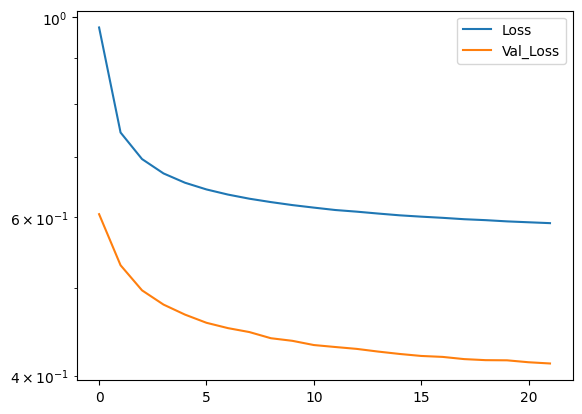

In [ ]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [ ]:
model_json = model.to_json()
with open("autoencoder_all.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("autoencoder_weights_all.h5")

### 6. load model

In [ ]:
from keras.models import model_from_json

json_file = open('autoencoder_all.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('autoencoder_weights_all.h5')

### 7. generator

#### 7.1 functions

In [ ]:
def one_hot_encode(tokenized_smiles):
        result = np.array([one_hot_dict[symbol] for symbol in tokenized_smiles], dtype=np.float32)
        result = result.reshape(1, result.shape[0], result.shape[1])
        return result

In [ ]:
def generate(sequence):
    while (sequence[-1] != 'E') and (len(tokenize(sequence)) <= config_smiles_max_length):
        x = one_hot_encode(tokenize(sequence))
        preds = model.predict_on_batch(x)[0][-1]
        next_idx = sample_with_temp(preds)
        sequence += table[next_idx]

    sequence = sequence[1:].rstrip('E')
    return sequence

In [ ]:
def sample_with_temp(preds):
        streched = np.log(preds) / config_sampling_temp
        streched_probs = np.exp(streched) / np.sum(np.exp(streched))
        return np.random.choice(range(len(streched)), p=streched_probs)

In [ ]:
def sample(num, start='G', valid_only = False):
    sampled = []
    if not valid_only:
        for _ in tqdm(range(num)):
            sampled.append(generate(start))
    else:
        while (len(sampled) < num):
            seq = generate(start)
            mol = Chem.MolFromSmiles(seq)
            if mol is not None:
                val_smile = Chem.MolToSmiles(mol)
                sampled.append(val_smile)
    return sampled

#### 7.2 generate mols

##### 7.2.1 generate with start molecule

In [ ]:
benz_sm = 'N=C(N)c1ccccc1'
benz = Chem.MolFromSmiles(benz_sm)
if benz is not None:
    print("valid")
    fragment_properties = calculate_properties(benz_sm)
    print(f"Starting Fragment Properties: {fragment_properties}")
else:
    print("not valid")

valid
Starting Fragment Properties: {'QED': 0.42078871213582203, 'MolecularWeight': 120.15499999999996, 'LogP': 0.9706700000000004, 'NumHDonors': 2, 'NumHAcceptors': 1}


In [ ]:
sample_with_start_molecule = sample(1000, start='GN=C(N)c1ccccc1')

100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


In [ ]:
"""with open("sampled_with_start_molecule_25_06_2024.smi", 'w') as file:
    # Iterate over each SMILES string and write it to the file
    for smile_line in sample_with_start_molecule:
        file.write(smile_line + '\n')""";

In [ ]:
#100% gia 10 samples
#86% gia 1000 samples

valid_sample_with_start_molecule = []
for smi in sample_with_start_molecule:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_sample_with_start_molecule.append(mol)
# low validity
print(f'{len(valid_sample_with_start_molecule) / 1000:.2%}')

85.40%


In [ ]:
#100% gia 10 samples
#97% gia 1000 samples

sample_with_start_molecule_smiles = [Chem.MolToSmiles(mol) for mol in valid_sample_with_start_molecule]
# high uniqueness
print(f'{len(set(sample_with_start_molecule_smiles)) / len(sample_with_start_molecule_smiles):.2%}')

97.31%


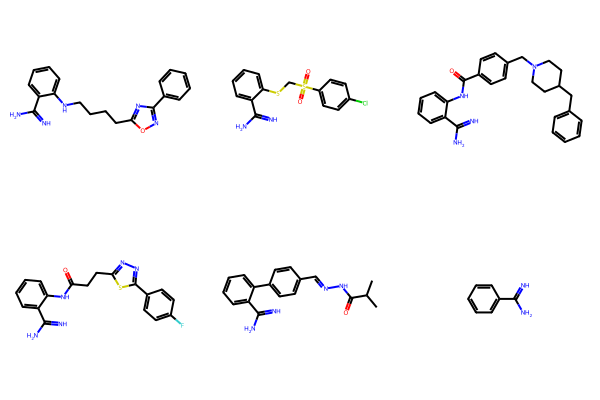

In [ ]:
Draw.MolsToGridImage(valid_sample_with_start_molecule[:5] + [benz])

In [ ]:
# Analyze generated molecules
generated_properties_list = [calculate_properties(smi) for smi in sample_with_start_molecule_smiles if calculate_properties(smi) is not None]
generated_properties_df = pd.DataFrame(generated_properties_list)

# Display summary statistics for generated molecules
print("Generated Molecules Properties:")
print(generated_properties_df.describe())

# Add the starting fragment properties to the DataFrame for comparison
fragment_properties_df = pd.DataFrame([fragment_properties])
comparison_df = pd.concat([fragment_properties_df, generated_properties_df], ignore_index=True)

# Display comparison
print("Comparison with Starting Fragment:")
print(comparison_df)


Generated Molecules Properties:
              QED  MolecularWeight        LogP  NumHDonors  NumHAcceptors
count  854.000000       854.000000  854.000000  854.000000     854.000000
mean     0.446141       364.742382    2.942571    3.107728       3.896956
std      0.123544        54.116593    1.126780    0.884999       1.305113
min      0.101371       240.262000   -0.611130    2.000000       1.000000
25%      0.356346       324.385000    2.131945    2.000000       3.000000
50%      0.454713       358.898000    2.960970    3.000000       4.000000
75%      0.540225       399.882000    3.706920    4.000000       5.000000
max      0.674538       554.735000    7.549470    7.000000      10.000000
Comparison with Starting Fragment:
          QED  MolecularWeight     LogP  NumHDonors  NumHAcceptors
0    0.420789          120.155  0.97067           2              1
1    0.332382          335.411  3.45547           3              5
2    0.497227          340.857  3.14757           2              4

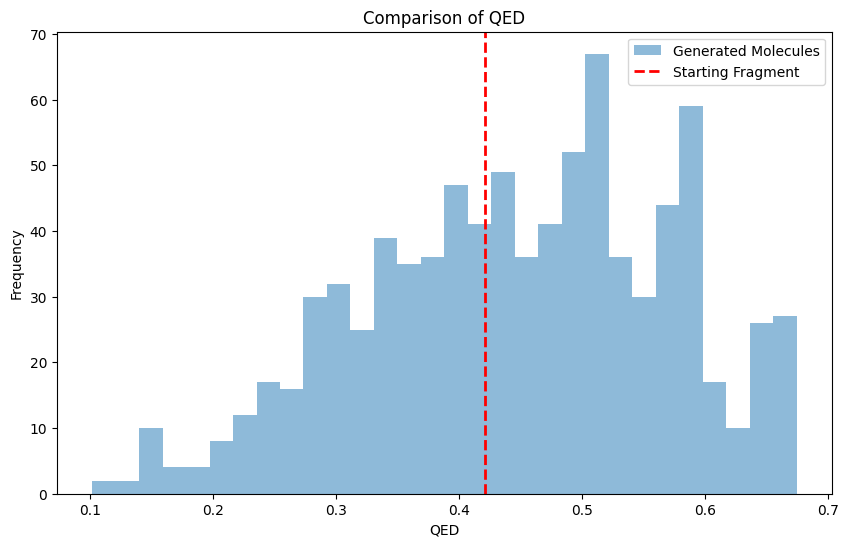

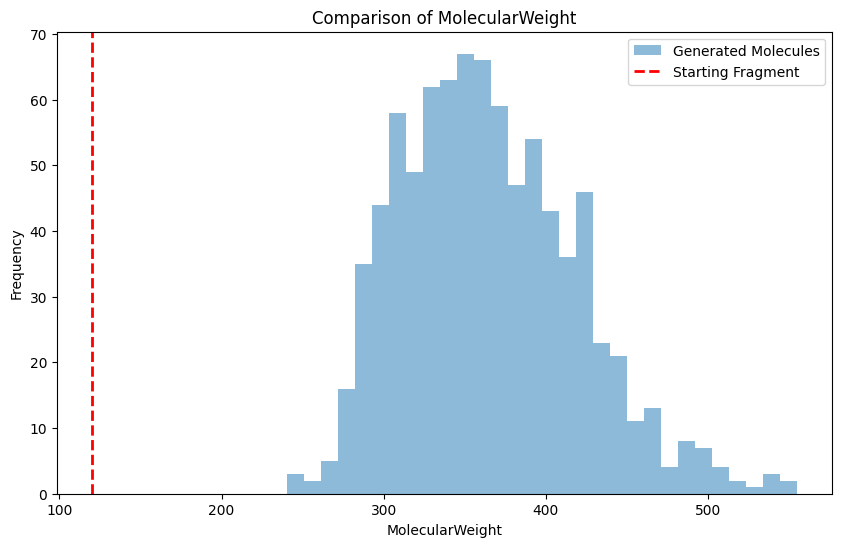

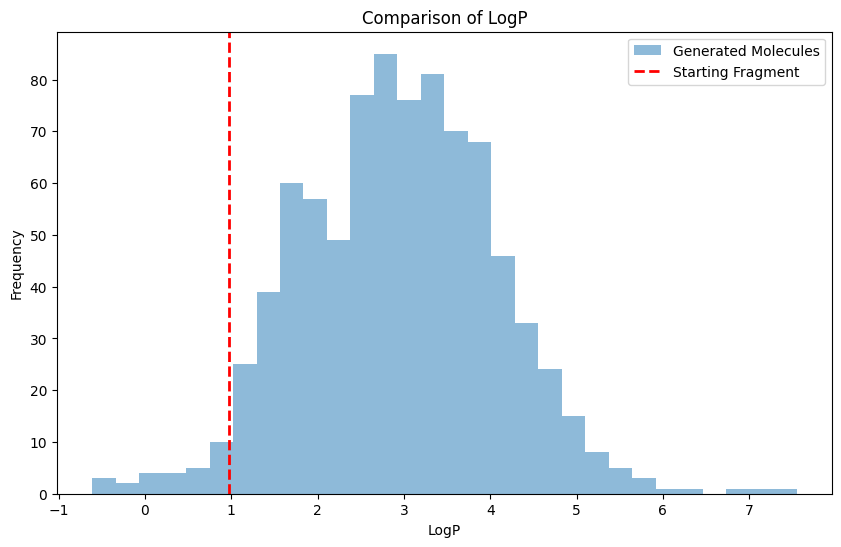

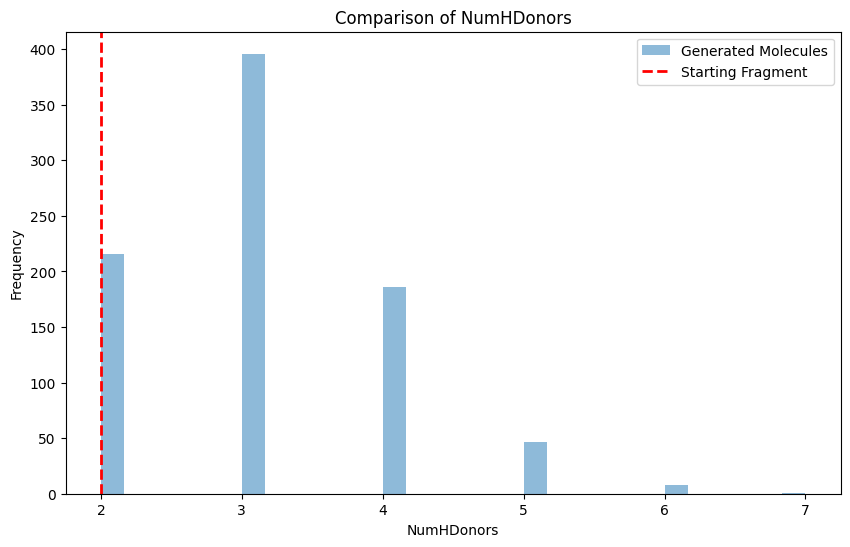

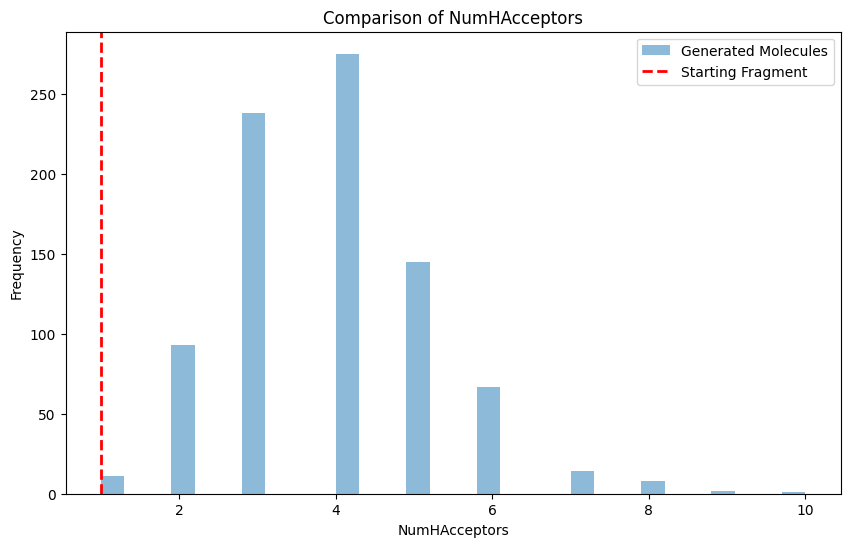

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize comparison
def plot_property_comparison(property_name, fragment_value, generated_values):
    plt.figure(figsize=(10, 6))
    plt.hist(generated_values, bins=30, alpha=0.5, label='Generated Molecules')
    plt.axvline(fragment_value, color='red', linestyle='dashed', linewidth=2, label='Starting Fragment')
    plt.title(f'Comparison of {property_name}')
    plt.xlabel(property_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot comparison for each property
for property_name in fragment_properties.keys():
    plot_property_comparison(property_name, fragment_properties[property_name], generated_properties_df[property_name])


##### 7.2.2 generate from scratch

In [ ]:
sampled = sample(1000)

100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


In [ ]:
"""with open("sampled_25_06_2024.smi", 'w') as file:
    # Iterate over each SMILES string and write it to the file
    for smile_line in sampled:
        file.write(smile_line + '\n')""";

In [ ]:
valid_mols = []
for smi in sampled:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)
# low validity
print(f'{len(valid_mols) / 1000:.2%}')

73.90%


In [ ]:
valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]
# high uniqueness
print(f'{len(set(valid_smiles)) / len(valid_smiles):.2%}')

100.00%


In [ ]:
with open('./chembl_500k_clean.smi') as f:
    org_smiles = [l.rstrip() for l in f]

org_mols = [mol for mol in [Chem.MolFromSmiles(smi) for smi in org_smiles[:10000]] if mol is not None]

In [ ]:
sum = 0

for smi in valid_smiles:
    if smi in org_smiles:
        sum+=1

print("number of mols not in database:", f'{(len(valid_smiles) - sum) / len(valid_smiles):.2%}')

number of mols not in database: 99.32%


#### 7.3 properties analysis

##### 7.3.1 analysis 1 (first/default)

In [ ]:
Vfps = []
for mol in valid_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps.append(fp)

Ofps = []
for mol in org_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps.append(fp)

In [ ]:
Vlen = len(Vfps)
x = Vfps + Ofps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

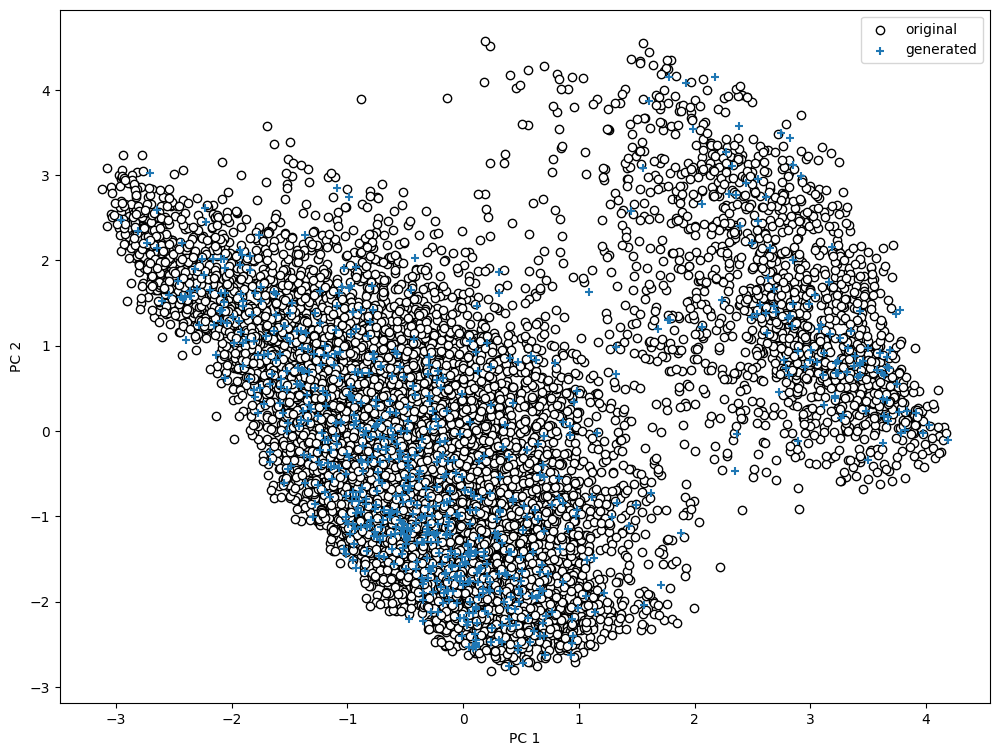

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(X[Vlen:, 0], X[Vlen:, 1], c='w', edgecolors='k', label='original')
plt.scatter(X[:Vlen, 0], X[:Vlen, 1], marker='+', label='generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In [ ]:
props = {
    'MW': {
        'generated': [Descriptors.ExactMolWt(mol) for mol in valid_mols],
        'original': [Descriptors.ExactMolWt(mol) for mol in org_mols]
    },
    'logP': {
        'generated': [Descriptors.MolLogP(mol) for mol in valid_mols],
        'original': [Descriptors.MolLogP(mol) for mol in org_mols]
    }
}

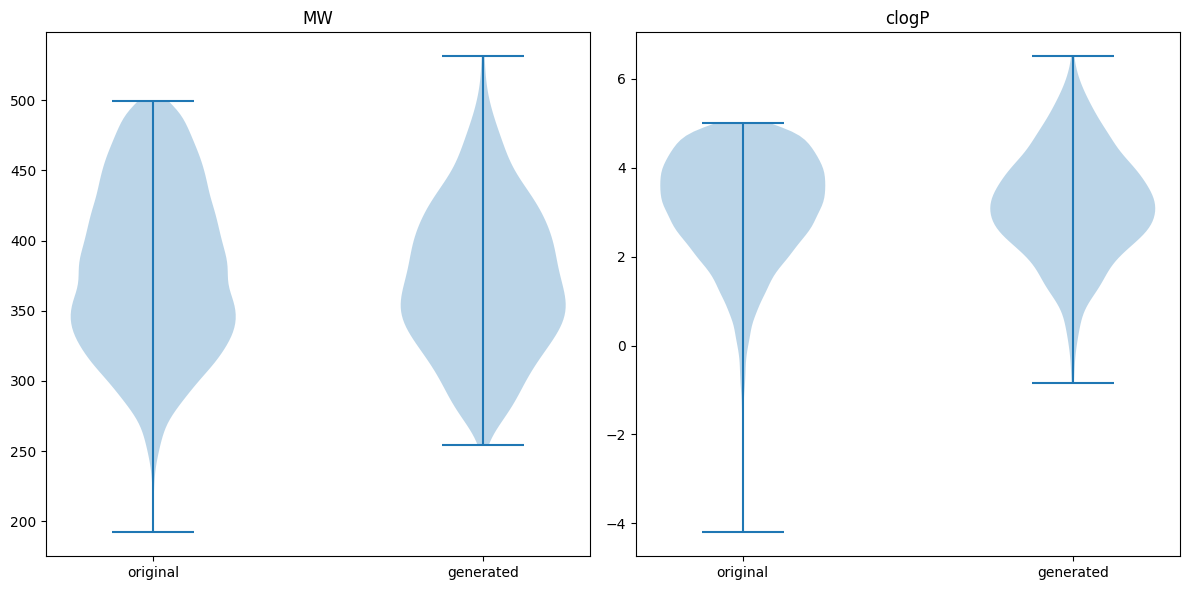

In [ ]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.violinplot([props['MW']['original'], props['MW']['generated']])
ax1.set_xticks(ticks=[1, 2])
ax1.set_xticklabels(labels=['original', 'generated'])
ax1.set_title('MW')

ax2 = fig.add_subplot(1, 2, 2)
ax2.violinplot([props['logP']['original'], props['logP']['generated']])
ax2.set_xticks(ticks=[1, 2])
ax2.set_xticklabels(labels=['original', 'generated'])
ax2.set_title('clogP')

plt.tight_layout()

##### 7.3.2 analysis 2 (more visual)bold text

In [ ]:
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    properties = {
        'QED': QED.qed(mol),
        'MolecularWeight': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol)
    }
    return properties

In [ ]:

org_smiles_1000 = random.choices(org_smiles, k=1000)

original_properties_list = [calculate_properties(smiles) for smiles in org_smiles_1000]
original_properties_list = [prop for prop in original_properties_list if prop is not None]

# Calculate properties for sampled SMILES
sampled_properties_list = [calculate_properties(smiles) for smiles in valid_smiles]
sampled_properties_list = [prop for prop in sampled_properties_list if prop is not None]

# Convert to DataFrames
original_properties_df = pd.DataFrame(original_properties_list)
sampled_properties_df = pd.DataFrame(sampled_properties_list)

print("Original SMILES Properties:")
print(original_properties_df.describe())
print("\nSampled SMILES Properties:")
print(sampled_properties_df.describe())

Original SMILES Properties:
               QED  MolecularWeight         LogP   NumHDonors  NumHAcceptors
count  1000.000000      1000.000000  1000.000000  1000.000000    1000.000000
mean      0.627344       379.173189     3.105612     1.369000       5.170000
std       0.169381        57.315808     1.192597     1.087208       1.711733
min       0.086706       234.215000    -2.293800     0.000000       1.000000
25%       0.494292       335.406000     2.351410     1.000000       4.000000
50%       0.644186       375.390500     3.224610     1.000000       5.000000
75%       0.765095       420.433000     4.024740     2.000000       6.000000
max       0.946346       499.015000     4.997300     5.000000      10.000000

Sampled SMILES Properties:
              QED  MolecularWeight        LogP  NumHDonors  NumHAcceptors
count  739.000000       739.000000  739.000000  739.000000     739.000000
mean     0.661969       370.780315    3.275320    1.324763       4.420839
std      0.164471        54.3

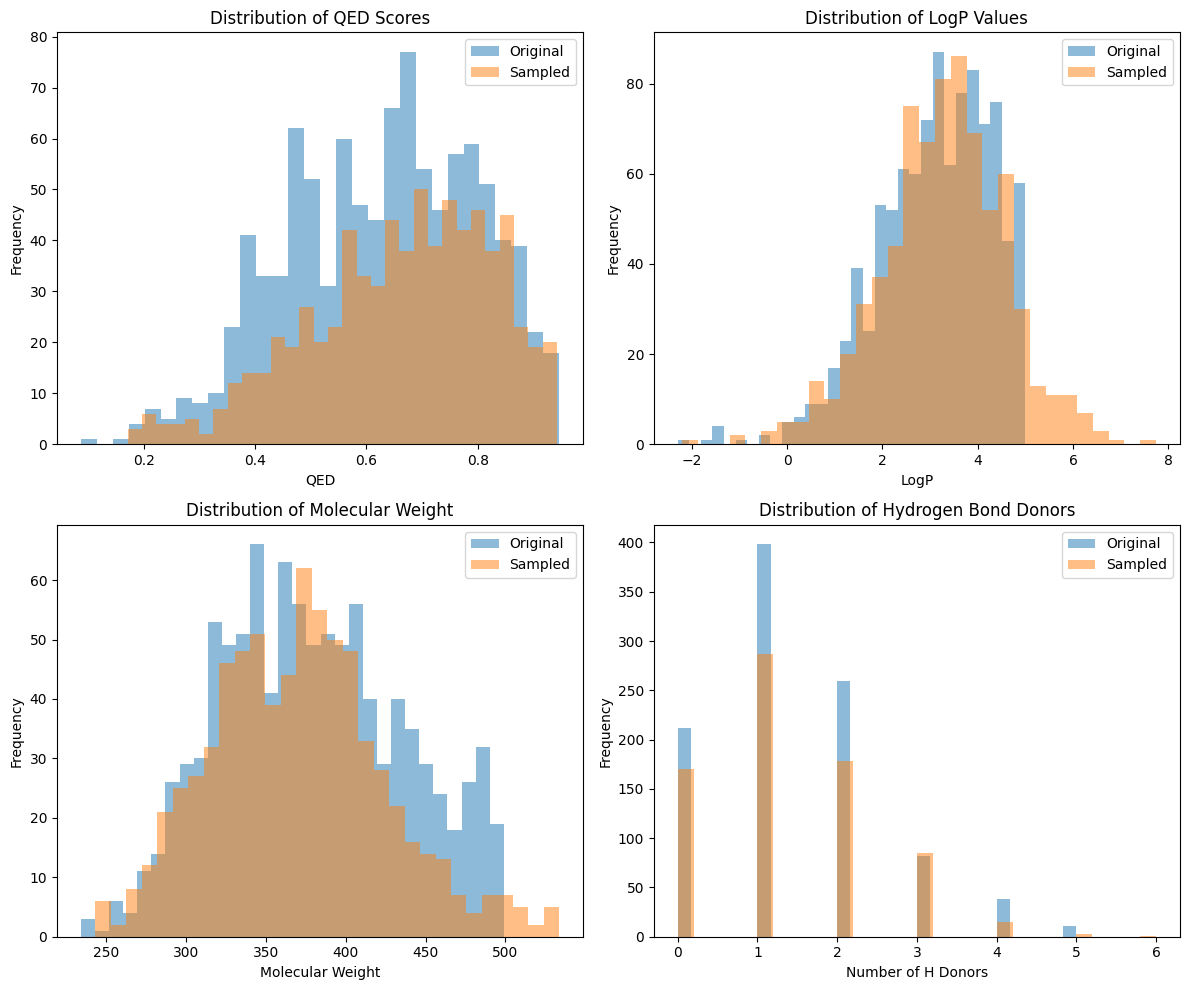

In [ ]:
# Plot distributions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# QED
axs[0, 0].hist(original_properties_df['QED'], bins=30, alpha=0.5, label='Original')
axs[0, 0].hist(sampled_properties_df['QED'], bins=30, alpha=0.5, label='Sampled')
axs[0, 0].set_title('Distribution of QED Scores')
axs[0, 0].set_xlabel('QED')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

# LogP
axs[0, 1].hist(original_properties_df['LogP'], bins=30, alpha=0.5, label='Original')
axs[0, 1].hist(sampled_properties_df['LogP'], bins=30, alpha=0.5, label='Sampled')
axs[0, 1].set_title('Distribution of LogP Values')
axs[0, 1].set_xlabel('LogP')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Molecular Weight
axs[1, 0].hist(original_properties_df['MolecularWeight'], bins=30, alpha=0.5, label='Original')
axs[1, 0].hist(sampled_properties_df['MolecularWeight'], bins=30, alpha=0.5, label='Sampled')
axs[1, 0].set_title('Distribution of Molecular Weight')
axs[1, 0].set_xlabel('Molecular Weight')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

# Number of H Donors
axs[1, 1].hist(original_properties_df['NumHDonors'], bins=30, alpha=0.5, label='Original')
axs[1, 1].hist(sampled_properties_df['NumHDonors'], bins=30, alpha=0.5, label='Sampled')
axs[1, 1].set_title('Distribution of Hydrogen Bond Donors')
axs[1, 1].set_xlabel('Number of H Donors')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

### 8. finetuner

#### 8.1 TR

##### load specific smiles and finetune

In [ ]:
from keras.models import model_from_json

json_file = open('autoencoder_all.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('autoencoder_weights_all.h5')

In [ ]:
TR_smiles = load_dataset(0, "TR_beta1_clean.smi")
TR_tokenized = tokenize_all(TR_smiles)
TR_padded_smiles = padding(TR_tokenized, max_len)

TR_X, TR_y = [], []
for tp_smi in TR_padded_smiles:
    X_temp = [one_hot_dict[symbol] for symbol in tp_smi[:-1]]
    TR_X.append(X_temp)
    y_temp = [one_hot_dict[symbol] for symbol in tp_smi[1:]]
    TR_y.append(y_temp)

TR_X = np.array(TR_X, dtype=np.uint8)
TR_y = np.array(TR_y, dtype=np.uint8)

loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 5149/5149 [00:00<00:00, 28702.57it/s]

done.


In [ ]:
model.compile(optimizer=config_optimizer, loss='categorical_crossentropy')

In [ ]:
h = model.fit(
        TR_X, TR_y,
        steps_per_epoch=np.ceil(TR_X.shape[0]/float(finetune_batch_size)),
        epochs=config_finetune_epochs,
        verbose=config_verbose_training,
        use_multiprocessing=True,
        shuffle=True)

Epoch 1/5
5149/5149 [==============================] - 67s 11ms/step - loss: 0.6537
Epoch 2/5
5149/5149 [==============================] - 66s 13ms/step - loss: 0.6366
Epoch 3/5
5149/5149 [==============================] - 67s 13ms/step - loss: 0.6237
Epoch 4/5
5149/5149 [==============================] - 74s 14ms/step - loss: 0.6179
Epoch 5/5
5149/5149 [==============================] - 51s 10ms/step - loss: 0.6059


In [ ]:
model_json = model.to_json()
with open("./TR_beta1/autoencoder_TR_beta1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./TR_beta1/autoencoder_weights_TR_beta1.h5")

##### load smiles, finetuned-model and generate

In [ ]:
with open('./TR_beta1_clean.smi') as f:
    org_smiles_TR = [l.rstrip() for l in f]

org_mols_TR = [mol for mol in [Chem.MolFromSmiles(smi) for smi in org_smiles_TR] if mol is not None]

In [ ]:
from keras.models import model_from_json

json_file = open('./TR_beta1/autoencoder_TR_beta1.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('./TR_beta1/autoencoder_weights_TR_beta1.h5')

In [ ]:
config_sampling_temp = 0.5 # 0.75 = 50.3% --- 0.5 = 71.3% k 86% valid smiles
sampled_TR = sample(1000)

100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s]


In [ ]:
valid_mols_TR = []
for smi in sampled_TR:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols_TR.append(mol)
# low validity
print(f'{len(valid_mols_TR) / 1000:.2%}')

71.30%


In [ ]:
valid_smiles_TR = [Chem.MolToSmiles(mol) for mol in valid_mols_TR]
# high uniqueness
print(f'{len(set(valid_smiles_TR)) / len(valid_smiles_TR):.2%}')

88.36%


In [ ]:
sum = 0

for smi in valid_smiles_TR:
    if smi in org_smiles_TR:
        sum+=1

print("number of mols not in database:", f'{(len(valid_smiles_TR) - sum) / len(valid_smiles_TR):.2%}')

number of mols not in database: 88.78%


##### properties analysis

In [ ]:
Vfps_TR = []
for mol in valid_mols_TR:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps_TR.append(fp)

Ofps_TR = []
for mol in org_mols_TR:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps_TR.append(fp)

In [ ]:
Vlen_TR = len(Vfps_TR)
x_TR = Vfps_TR + Ofps_TR
pca = PCA(n_components=2, random_state=71)
X_TR = pca.fit_transform(x_TR)

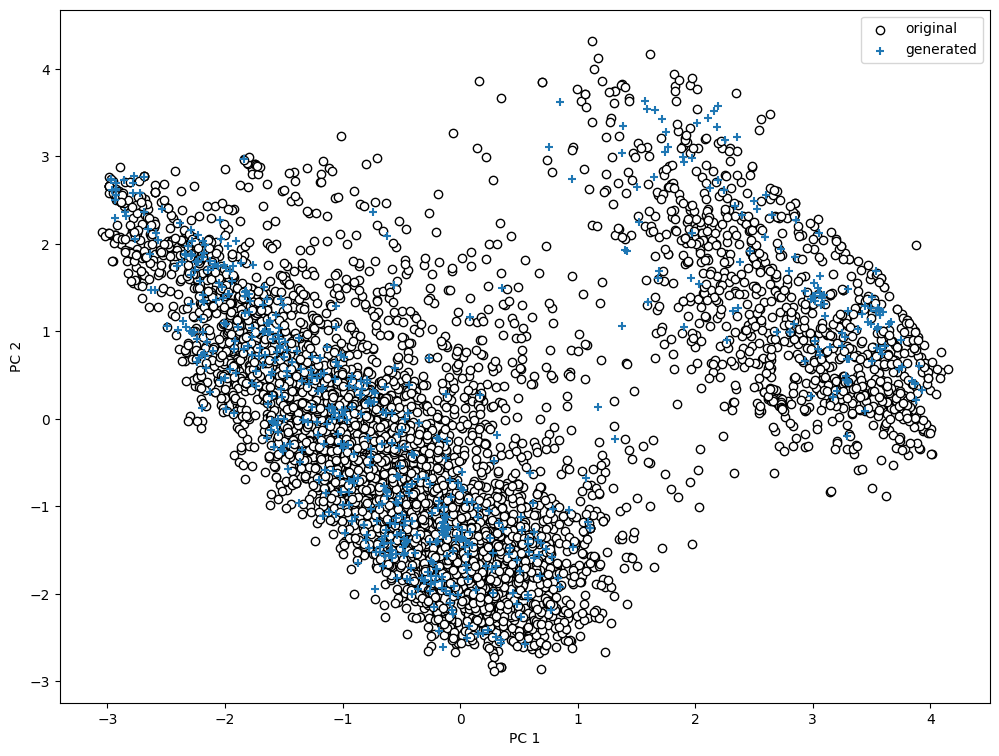

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(X_TR[Vlen_TR:, 0], X_TR[Vlen_TR:, 1], c='w', edgecolors='k', label='original')
plt.scatter(X_TR[:Vlen_TR, 0], X_TR[:Vlen_TR, 1], marker='+', label='generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

#### 8.2 MMP-1

 ##### load specific smiles and finetune

In [ ]:
from keras.models import model_from_json

json_file = open('autoencoder_all.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('autoencoder_weights_all.h5')

In [ ]:
MMP_smiles = load_dataset(0, "MMP-1_clean.smi")
MMP_tokenized = tokenize_all(MMP_smiles)
MMP_padded_smiles = padding(MMP_tokenized, max_len)

MMP_X, MMP_y = [], []
for tp_smi in MMP_padded_smiles:
    X_temp = [one_hot_dict[symbol] for symbol in tp_smi[:-1]]
    MMP_X.append(X_temp)
    y_temp = [one_hot_dict[symbol] for symbol in tp_smi[1:]]
    MMP_y.append(y_temp)

MMP_X = np.array(MMP_X, dtype=np.uint8)
MMP_y = np.array(MMP_y, dtype=np.uint8)

loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 4073/4073 [00:00<00:00, 26174.72it/s]

done.


In [ ]:
model.compile(optimizer=config_optimizer, loss='categorical_crossentropy')

In [ ]:
h = model.fit(
        MMP_X, MMP_y,
        steps_per_epoch=np.ceil(MMP_X.shape[0]/float(finetune_batch_size)),
        epochs=config_finetune_epochs,
        verbose=config_verbose_training,
        use_multiprocessing=True,
        shuffle=True)

Epoch 1/5
4073/4073 [==============================] - 44s 10ms/step - loss: 0.6062
Epoch 2/5
4073/4073 [==============================] - 38s 9ms/step - loss: 0.5545
Epoch 3/5
4073/4073 [==============================] - 37s 9ms/step - loss: 0.5293
Epoch 4/5
4073/4073 [==============================] - 38s 9ms/step - loss: 0.5066
Epoch 5/5
4073/4073 [==============================] - 35s 9ms/step - loss: 0.4942


In [ ]:
model_json = model.to_json()
with open("./MMP-1/autoencoder_MMP-1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./MMP-1/autoencoder_weights_MMP-1.h5")

##### load smiles, finetuned-model and generate




In [ ]:
with open('./MMP-1_clean.smi') as f:
    org_smiles_MMP = [l.rstrip() for l in f]

org_mols_MMP = [mol for mol in [Chem.MolFromSmiles(smi) for smi in org_smiles_MMP] if mol is not None]

In [ ]:
from keras.models import model_from_json

json_file = open('./MMP-1/autoencoder_MMP-1.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('./MMP-1/autoencoder_weights_MMP-1.h5')

In [ ]:
config_sampling_temp = 0.5 # 0.75 = 55% --- 0.5 = 71.2%
sampled_MMP = sample(1000)

100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]


In [ ]:
valid_mols_MMP = []
for smi in sampled_MMP:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols_MMP.append(mol)
# low validity
print(f'{len(valid_mols_MMP) / 1000:.2%}')

71.20%


In [ ]:
valid_smiles_MMP = [Chem.MolToSmiles(mol) for mol in valid_mols_MMP]
# high uniqueness
print(f'{len(set(valid_smiles_MMP)) / len(valid_smiles_MMP):.2%}')

74.30%


In [ ]:
sum = 0

for smi in valid_smiles_MMP:
    if smi in org_smiles_MMP:
        sum+=1

print("number of mols not in database:", f'{(len(valid_smiles_MMP) - sum) / len(valid_smiles_MMP):.2%}')

number of mols not in database: 88.90%


##### properties analysis

In [ ]:
Vfps_MMP = []
for mol in valid_mols_MMP:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps_MMP.append(fp)

Ofps_MMP = []
for mol in org_mols_MMP:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps_MMP.append(fp)

In [ ]:
Vlen_MMP = len(Vfps_MMP)
x_MMP = Vfps_MMP + Ofps_MMP
pca = PCA(n_components=2, random_state=71)
X_MMP = pca.fit_transform(x_MMP)

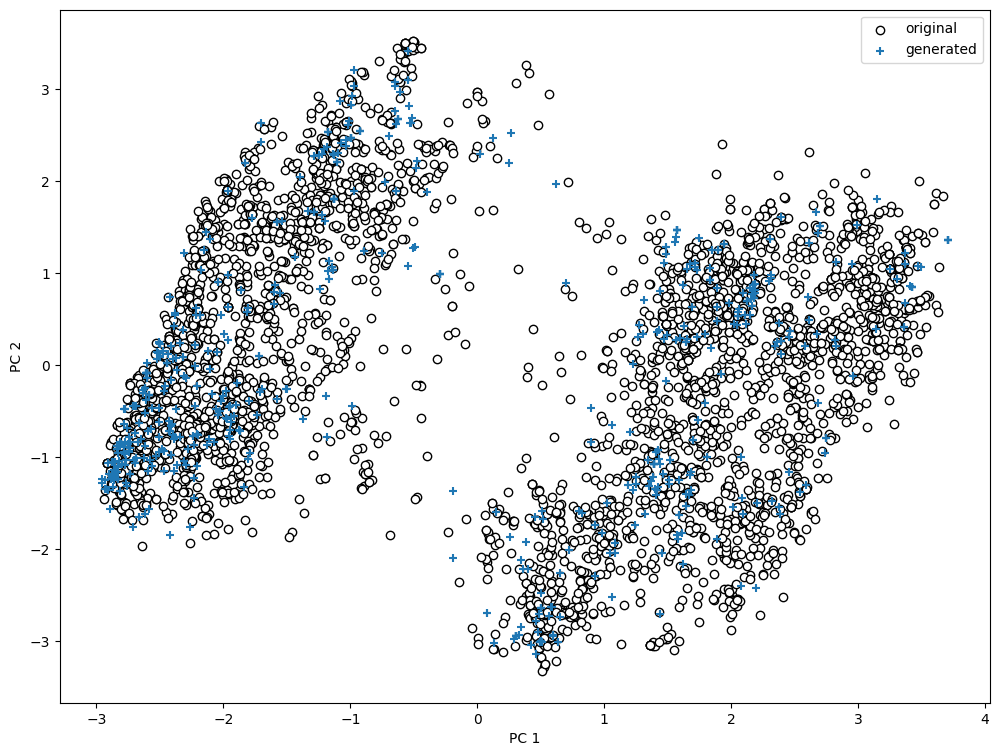

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(X_MMP[Vlen_MMP:, 0], X_MMP[Vlen_MMP:, 1], c='w', edgecolors='k', label='original')
plt.scatter(X_MMP[:Vlen_MMP, 0], X_MMP[:Vlen_MMP, 1], marker='+', label='generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

#### 8.3 LXR_beta

##### load specific smiles and finetune

In [ ]:
from keras.models import model_from_json

json_file = open('autoencoder_all.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('autoencoder_weights_all.h5')

In [ ]:
LXR_smiles = load_dataset(0, "LXR_beta_clean.smi")
LXR_tokenized = tokenize_all(LXR_smiles)
LXR_padded_smiles = padding(LXR_tokenized, max_len)

LXR_X, LXR_y = [], []
for tp_smi in LXR_padded_smiles:
    X_temp = [one_hot_dict[symbol] for symbol in tp_smi[:-1]]
    LXR_X.append(X_temp)
    y_temp = [one_hot_dict[symbol] for symbol in tp_smi[1:]]
    LXR_y.append(y_temp)

LXR_X = np.array(LXR_X, dtype=np.uint8)
LXR_y = np.array(LXR_y, dtype=np.uint8)

loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 1359/1359 [00:00<00:00, 29318.12it/s]

done.


In [ ]:
model.compile(optimizer=config_optimizer, loss='categorical_crossentropy')

In [ ]:
h = model.fit(
        LXR_X, LXR_y,
        steps_per_epoch=np.ceil(LXR_X.shape[0]/float(finetune_batch_size)),
        epochs=config_finetune_epochs,
        verbose=config_verbose_training,
        use_multiprocessing=True,
        shuffle=True)

Epoch 1/5
1359/1359 [==============================] - 22s 9ms/step - loss: 0.6252
Epoch 2/5
1359/1359 [==============================] - 10s 8ms/step - loss: 0.5591
Epoch 3/5
1359/1359 [==============================] - 11s 8ms/step - loss: 0.5179
Epoch 4/5
1359/1359 [==============================] - 11s 8ms/step - loss: 0.5024
Epoch 5/5
1359/1359 [==============================] - 11s 8ms/step - loss: 0.4883


In [ ]:
model_json = model.to_json()
with open("./LXR_beta/autoencoder_LXR_beta.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./LXR_beta/autoencoder_weights_LXR_beta.h5")

##### load smiles, finetuned-model and generate

In [ ]:
with open('./LXR_beta_clean.smi') as f:
    org_smiles_LXR = [l.rstrip() for l in f]

org_mols_LXR = [mol for mol in [Chem.MolFromSmiles(smi) for smi in org_smiles_LXR] if mol is not None]

In [ ]:
from keras.models import model_from_json

json_file = open('./LXR_beta/autoencoder_LXR_beta.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('./LXR_beta/autoencoder_weights_LXR_beta.h5')

In [ ]:
config_sampling_temp = 0.5   # 0.75 = 54.2% --- 0.5 = 73.7%
sampled_LXR = sample(1000)

100%|██████████| 1000/1000 [07:23<00:00,  2.25it/s]


In [ ]:
valid_mols_LXR = []
for smi in sampled_LXR:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols_LXR.append(mol)
# low validity
print(f'{len(valid_mols_LXR) / 1000:.2%}')

73.70%


In [ ]:
valid_smiles_LXR = [Chem.MolToSmiles(mol) for mol in valid_mols_LXR]
# high uniqueness
print(f'{len(set(valid_smiles_LXR)) / len(valid_smiles_LXR):.2%}')

49.53%


In [ ]:
sum = 0

for smi in valid_smiles_LXR:
    if smi in org_smiles_LXR:
        sum+=1

print("number of mols not in database:", f'{(len(valid_smiles_LXR) - sum) / len(valid_smiles_LXR):.2%}')

number of mols not in database: 67.84%


##### properties analysis

In [ ]:
Vfps_LXR = []
for mol in valid_mols_LXR:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps_LXR.append(fp)

Ofps_LXR = []
for mol in org_mols_LXR:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps_LXR.append(fp)

In [ ]:
Vlen_LXR = len(Vfps_LXR)
x_LXR = Vfps_LXR + Ofps_LXR
pca = PCA(n_components=2, random_state=71)
X_LXR = pca.fit_transform(x_LXR)

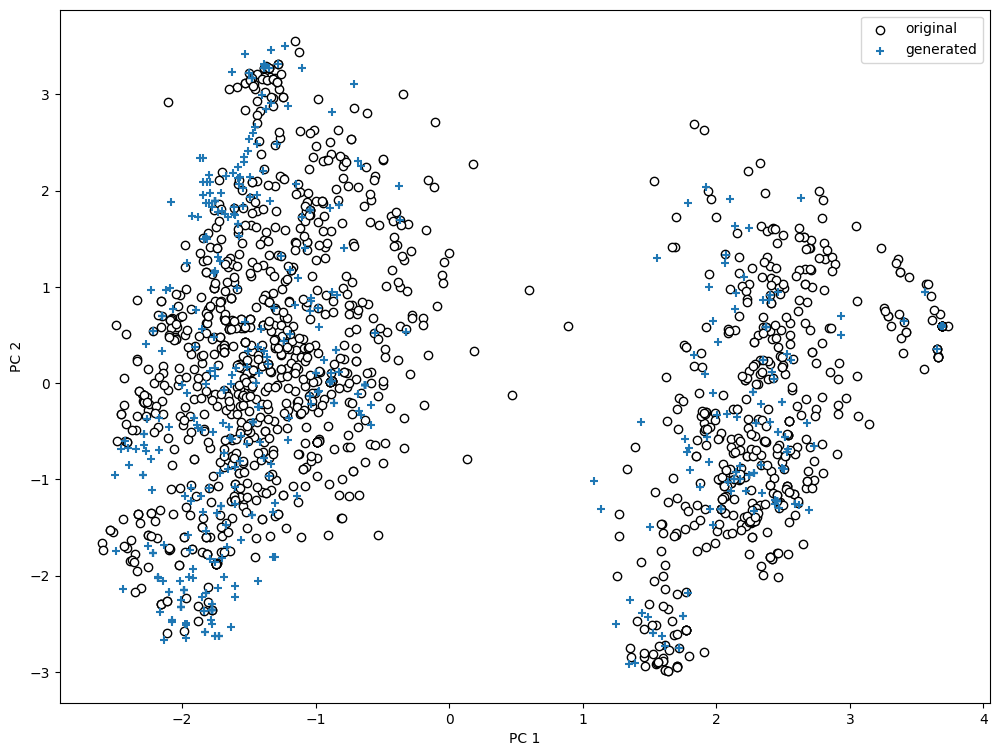

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(X_LXR[Vlen_LXR:, 0], X_LXR[Vlen_LXR:, 1], c='w', edgecolors='k', label='original')
plt.scatter(X_LXR[:Vlen_LXR, 0], X_LXR[:Vlen_LXR, 1], marker='+', label='generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

#### 8.4 PPAR_gamma

##### load specific smiles and finetune

In [ ]:
from keras.models import model_from_json

json_file = open('autoencoder_all.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('autoencoder_weights_all.h5')

In [ ]:
PPAR_smiles = load_dataset(0, "PPAR_gamma_clean.smi")
PPAR_tokenized = tokenize_all(PPAR_smiles)
PPAR_padded_smiles = padding(PPAR_tokenized, max_len)

PPAR_X, PPAR_y = [], []
for tp_smi in PPAR_padded_smiles:
    X_temp = [one_hot_dict[symbol] for symbol in tp_smi[:-1]]
    PPAR_X.append(X_temp)
    y_temp = [one_hot_dict[symbol] for symbol in tp_smi[1:]]
    PPAR_y.append(y_temp)

PPAR_X = np.array(PPAR_X, dtype=np.uint8)
PPAR_y = np.array(PPAR_y, dtype=np.uint8)

loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 6326/6326 [00:00<00:00, 14298.91it/s]


done.


In [ ]:
model.compile(optimizer=config_optimizer, loss='categorical_crossentropy')

In [ ]:
h = model.fit(
        PPAR_X, PPAR_y,
        steps_per_epoch=np.ceil(PPAR_X.shape[0]/float(finetune_batch_size)),
        epochs=config_finetune_epochs,
        verbose=config_verbose_training,
        use_multiprocessing=True,
        shuffle=True)

Epoch 1/5
6326/6326 [==============================] - 64s 9ms/step - loss: 0.6376
Epoch 2/5
6326/6326 [==============================] - 60s 9ms/step - loss: 0.5844
Epoch 3/5
6326/6326 [==============================] - 58s 9ms/step - loss: 0.5593
Epoch 4/5
6326/6326 [==============================] - 64s 10ms/step - loss: 0.5335
Epoch 5/5
6326/6326 [==============================] - 79s 12ms/step - loss: 0.5250


In [ ]:
model_json = model.to_json()
with open("./PPAR_gamma/autoencoder_PPAR_gamma.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./PPAR_gamma/autoencoder_weights_PPAR_gamma.h5")

##### load smiles, finetuned-model and generate

In [ ]:
with open('./PPAR_gamma_clean.smi') as f:
    org_smiles_PPAR = [l.rstrip() for l in f]

org_mols_PPAR = [mol for mol in [Chem.MolFromSmiles(smi) for smi in org_smiles_PPAR] if mol is not None]

In [ ]:
from keras.models import model_from_json

json_file = open('./PPAR_gamma/autoencoder_PPAR_gamma.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('./PPAR_gamma/autoencoder_weights_PPAR_gamma.h5')

In [ ]:
config_sampling_temp = 0.5  #0.75 = 0.5% --- 0.5 = 74.6%
sampled_PPAR = sample(1000)

100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


In [ ]:
valid_mols_PPAR = []
for smi in sampled_PPAR:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols_PPAR.append(mol)
# low validity
print(f'{len(valid_mols_PPAR) / 1000:.2%}')

746.00%


In [ ]:
valid_smiles_PPAR = [Chem.MolToSmiles(mol) for mol in valid_mols_PPAR]
# high uniqueness
print(f'{len(set(valid_smiles_PPAR)) / len(valid_smiles_PPAR):.2%}')

80.56%


In [ ]:
sum = 0

for smi in valid_smiles_PPAR:
    if smi in org_smiles_PPAR:
        sum+=1

print("number of mols not in database:", f'{(len(valid_smiles_PPAR) - sum) / len(valid_smiles_PPAR):.2%}')

number of mols not in database: 86.06%


##### properties analysis

In [ ]:
Vfps_PPAR = []
for mol in valid_mols_PPAR:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps_PPAR.append(fp)

Ofps_PPAR = []
for mol in org_mols_PPAR:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps_PPAR.append(fp)

In [ ]:
Vlen_PPAR = len(Vfps_PPAR)
x_PPAR = Vfps_PPAR + Ofps_PPAR
pca = PCA(n_components=2, random_state=71)
X_PPAR = pca.fit_transform(x_PPAR)

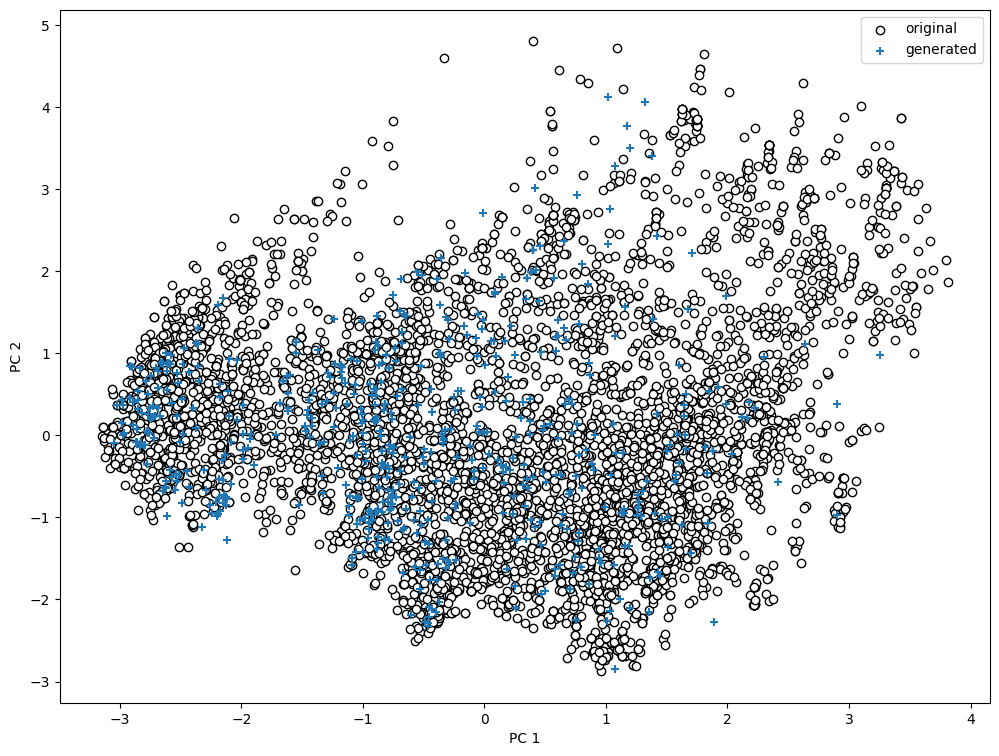

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(X_PPAR[Vlen_PPAR:, 0], X_PPAR[Vlen_PPAR:, 1], c='w', edgecolors='k', label='original')
plt.scatter(X_PPAR[:Vlen_PPAR, 0], X_PPAR[:Vlen_PPAR, 1], marker='+', label='generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

#### 8.5 DPP-4

##### load specific smiles and finetune

In [ ]:
from keras.models import model_from_json

json_file = open('autoencoder_all.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('autoencoder_weights_all.h5')

In [ ]:
DPP_smiles = load_dataset(0, "DPP-4_clean.smi")
DPP_tokenized = tokenize_all(DPP_smiles)
DPP_padded_smiles = padding(DPP_tokenized, max_len)

DPP_X, DPP_y = [], []
for tp_smi in DPP_padded_smiles:
    X_temp = [one_hot_dict[symbol] for symbol in tp_smi[:-1]]
    DPP_X.append(X_temp)
    y_temp = [one_hot_dict[symbol] for symbol in tp_smi[1:]]
    DPP_y.append(y_temp)

DPP_X = np.array(DPP_X, dtype=np.uint8)
DPP_y = np.array(DPP_y, dtype=np.uint8)

loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 4078/4078 [00:00<00:00, 35001.03it/s]

done.


In [ ]:
model.compile(optimizer=config_optimizer, loss='categorical_crossentropy')

In [ ]:
h = model.fit(
        DPP_X, DPP_y,
        steps_per_epoch=np.ceil(DPP_X.shape[0]/float(finetune_batch_size)),
        epochs=config_finetune_epochs,
        verbose=config_verbose_training,
        use_multiprocessing=True,
        shuffle=True)

Epoch 1/5
4078/4078 [==============================] - 42s 9ms/step - loss: 0.5752
Epoch 2/5
4078/4078 [==============================] - 36s 9ms/step - loss: 0.5132
Epoch 3/5
4078/4078 [==============================] - 35s 9ms/step - loss: 0.4820
Epoch 4/5
4078/4078 [==============================] - 37s 9ms/step - loss: 0.4665
Epoch 5/5
4078/4078 [==============================] - 36s 9ms/step - loss: 0.4533


In [ ]:
model_json = model.to_json()
with open("./DPP-4/autoencoder_DPP-4.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./DPP-4/autoencoder_weights_DPP-4.h5")

##### load smiles, finetuned-model and generate

In [ ]:
with open('./DPP-4_clean.smi') as f:
    org_smiles_DPP = [l.rstrip() for l in f]

org_mols_DPP = [mol for mol in [Chem.MolFromSmiles(smi) for smi in org_smiles_DPP] if mol is not None]

In [ ]:
from keras.models import model_from_json

json_file = open('./DPP-4/autoencoder_DPP-4.json', 'r')
loaded = json_file.read()
json_file.close()
model = model_from_json(loaded)
model.load_weights('./DPP-4/autoencoder_weights_DPP-4.h5')

In [ ]:
config_sampling_temp = 0.5  #0.75 = 59.1% --- 0.5 = 79.3%
sampled_DPP = sample(1000)

100%|██████████| 1000/1000 [07:17<00:00,  2.29it/s]


In [ ]:
valid_mols_DPP = []
for smi in sampled_DPP:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols_DPP.append(mol)
# low validity
print(f'{len(valid_mols_DPP) / 1000:.2%}')

79.30%


In [ ]:
valid_smiles_DPP = [Chem.MolToSmiles(mol) for mol in valid_mols_DPP]
# high uniqueness
print(f'{len(set(valid_smiles_DPP)) / len(valid_smiles_DPP):.2%}')

54.85%


In [ ]:
sum = 0

for smi in valid_smiles_DPP:
    if smi in org_smiles_DPP:
        sum+=1

print("number of mols not in database:", f'{(len(valid_smiles_DPP) - sum) / len(valid_smiles_DPP):.2%}')

number of mols not in database: 67.47%


##### properties analysis

In [ ]:
Vfps_DPP = []
for mol in valid_mols_DPP:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps_DPP.append(fp)

Ofps_DPP = []
for mol in org_mols_DPP:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps_DPP.append(fp)

In [ ]:
Vlen_DPP = len(Vfps_DPP)
x_DPP = Vfps_DPP + Ofps_DPP
pca = PCA(n_components=2, random_state=71)
X_DPP = pca.fit_transform(x_DPP)

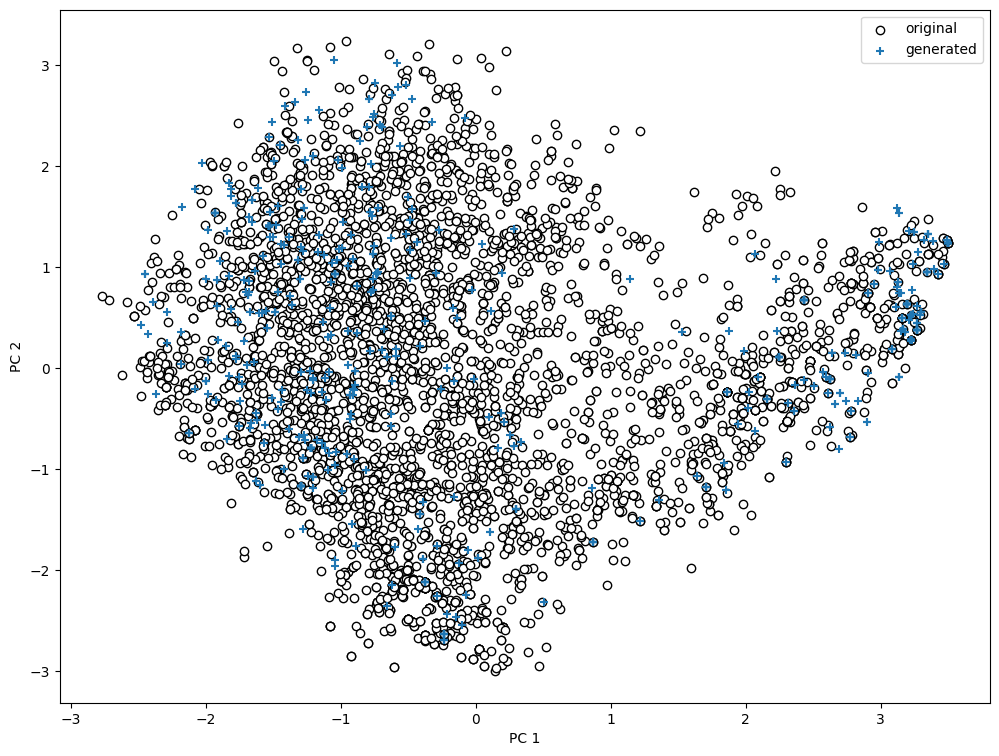

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(X_DPP[Vlen_DPP:, 0], X_DPP[Vlen_DPP:, 1], c='w', edgecolors='k', label='original')
plt.scatter(X_DPP[:Vlen_DPP, 0], X_DPP[:Vlen_DPP, 1], marker='+', label='generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

#### 8.6 compare

In [ ]:
finetuned_smiles = sample(100, valid_only = True)

In [ ]:
with open('./known_TRPM8-inhibitors_cleansed.smi') as f:
    ksmiles = [l.rstrip() for l in f]
kmols = [Chem.MolFromSmiles(smi) for smi in ksmiles]

Kfps = []
for mol in kmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Kfps.append(fp)

Klen = len(Kfps)

In [ ]:
with open('./TRPM8_inhibitors_for_fine-tune.smi') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Ffps, Fbvs = [], []
for mol in fmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)

    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ffps.append(fp)

Flen = len(Ffps)

In [ ]:
Sfps, Sbvs, smols = [], [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)

    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)

    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Sfps.append(fp)

In [ ]:
x = Kfps + Ffps + Sfps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

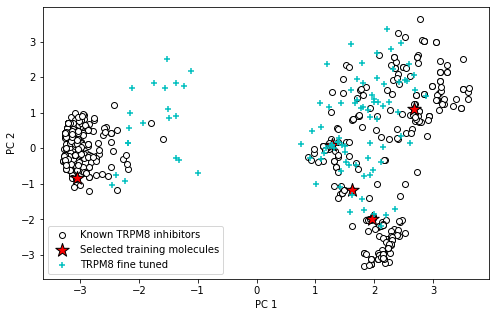

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:Klen, 0], X[:Klen, 1],
            c='w', edgecolors='k', label='Known TRPM8 inhibitors')
plt.scatter(X[Klen:Klen + Flen, 0], X[Klen:Klen + Flen, 1],
            s=200, c='r', marker='*', edgecolors='k', label='Selected training molecules')
plt.scatter(X[Klen + Flen:, 0], X[Klen + Flen:, 1],
            c='c', marker='+', label='TRPM8 fine tuned')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In [ ]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

In [ ]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

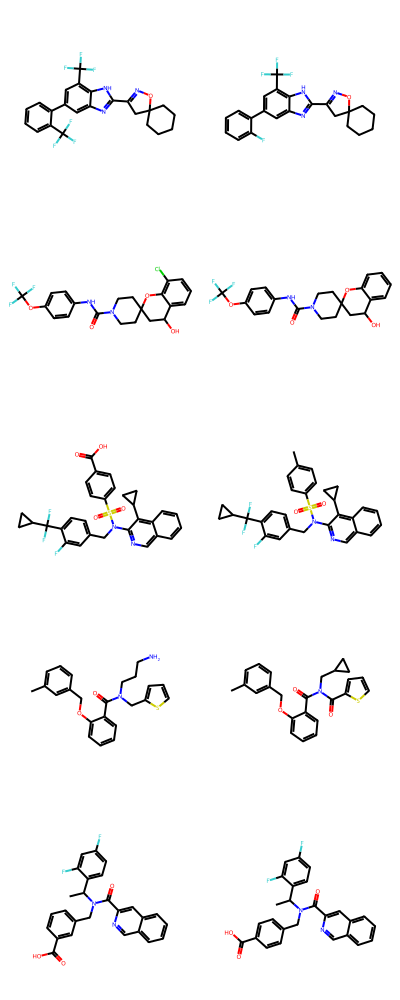

In [ ]:
Draw.MolsToGridImage(showmols, molsPerRow=2)

### 9. testing code

#### 10.1 find best parameters

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

def create_model(units=256, dropout_rate=0.3, optimizer='adam'):
    model = Sequential()
    model.add(
        LSTM(units=units,
             input_shape=(None, vect_len),
             return_sequences=True,
             kernel_initializer=weight_init,
             dropout=dropout_rate))
    model.add(
        LSTM(units=units,
             return_sequences=True,
             kernel_initializer=weight_init,
             dropout=dropout_rate))
    model.add(
        Dense(units=vect_len,
              activation='softmax',
              kernel_initializer=weight_init))

    if optimizer == 'adam':
        optimizer = Adam()
    elif optimizer == 'rmsprop':
        optimizer = RMSprop()

    model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    return model


In [ ]:
def train_and_evaluate_model(units, dropout_rate, optimizer, batch_size, epochs):
    model = create_model(units, dropout_rate, optimizer)

    # Define callbacks
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(config_checkpoint_dir, 'test-%s-{epoch:02d}-{val_loss:.2f}.hdf5' % config_exp_name),
        monitor=config_checkpoint_monitor,
        mode=config_checkpoint_mode,
        save_best_only=config_checkpoint_save_best_only,
        save_weights_only=config_checkpoint_save_weights_only,
        verbose=config_checkpoint_verbose)

    tensorboard = TensorBoard(
        log_dir=config_tensorboard_log_dir,
        write_graph=config_tensorboard_write_graph)

    history = model.fit(
        X_train, y_train,
        steps_per_epoch=np.ceil(X_train.shape[0]/float(batch_size)),
        epochs=epochs,
        verbose=config_verbose_training,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        validation_steps=np.ceil(X_val.shape[0]/float(batch_size)),
        use_multiprocessing=True,
        shuffle=True,
        callbacks=[checkpoint, tensorboard]
    )

    return history.history['val_loss'][-1]


In [ ]:
param_grid = {
    'units': [128, 256, 512],
    'dropout_rate': [0.3, 0.4, 0.5],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

In [ ]:
results = []

for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for optimizer in param_grid['optimizer']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    val_loss = train_and_evaluate_model(units, dropout_rate, optimizer, batch_size, epochs)
                    results.append({
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'optimizer': optimizer,
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'val_loss': val_loss
                    })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)


Epoch 1/10
14063/14063 [==============================] - ETA: 0s - loss: 0.8371
Epoch 1: saving model to ./checkpoints/test-LSTM_thesis-01-0.53.hdf5
14063/14063 [==============================] - 170s 12ms/step - loss: 0.8371 - val_loss: 0.5276
Epoch 2/10
14063/14063 [==============================] - ETA: 0s - loss: 0.6927
Epoch 2: saving model to ./checkpoints/test-LSTM_thesis-02-0.49.hdf5
14063/14063 [==============================] - 162s 12ms/step - loss: 0.6927 - val_loss: 0.4908
Epoch 3/10
14062/14063 [============================>.] - ETA: 0s - loss: 0.6692
Epoch 3: saving model to ./checkpoints/test-LSTM_thesis-03-0.48.hdf5
14063/14063 [==============================] - 164s 12ms/step - loss: 0.6692 - val_loss: 0.4761
Epoch 4/10
 2683/14063 [====>.........................] - ETA: 2:01 - loss: 0.6612

KeyboardInterrupt: 

#### 10.2 low-data testing and training

##### 10.2.1 load and finetune on specific dataset

In [ ]:
from keras.models import model_from_json

json_file = open('autoencoder_all.json', 'r')
loaded = json_file.read()
json_file.close()
base_model = model_from_json(loaded)
base_model.load_weights('autoencoder_weights_all.h5')

base_model.compile(optimizer='adam', loss='categorical_crossentropy')  # Adjust optimizer and loss as necessary


In [ ]:
def fine_tune_model(base_model, X_target, y_target, fine_tune_epochs=5, batch_size=32):
    history = base_model.fit(
        X_target, y_target,
        epochs=fine_tune_epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )
    return base_model, history

def generate_ft(sequence):
    while (sequence[-1] != 'E') and (len(tokenize(sequence)) <= config_smiles_max_length):
        x = one_hot_encode(tokenize(sequence))
        preds = base_model.predict_on_batch(x)[0][-1]
        next_idx = sample_with_temp(preds)
        sequence += table[next_idx]

    sequence = sequence[1:].rstrip('E')
    return sequence

def sample_ft(num, start='G', valid_only = False):
    sampled = []
    if not valid_only:
        for _ in tqdm(range(num)):
            sampled.append(generate_ft(start))
    else:
        while (len(sampled) < num):
            seq = generate_ft(start)
            mol = Chem.MolFromSmiles(seq)
            if mol is not None:
                val_smile = Chem.MolToSmiles(mol)
                sampled.append(val_smile)
    return sampled

In [ ]:
TR_smiles_all = load_dataset(0, "TR_beta1_clean.smi")
TR_smiles_10 = random.choices(TR_smiles_all, k=10)
TR_tokenized_10 = tokenize_all(TR_smiles_10)
TR_padded_smiles_10 = padding(TR_tokenized_10, max_len)

X_target, y_target = [], []
for tp_smi in TR_padded_smiles_10:
    X_temp = [one_hot_dict[symbol] for symbol in tp_smi[:-1]]
    X_target.append(X_temp)
    y_temp = [one_hot_dict[symbol] for symbol in tp_smi[1:]]
    y_target.append(y_temp)

X_target = np.array(X_target, dtype=np.uint8)
y_target = np.array(y_target, dtype=np.uint8)

loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 10/10 [00:00<00:00, 8698.27it/s]

done.


In [ ]:
fine_tuned_model, fine_tune_history = fine_tune_model(base_model, X_target, y_target)

Epoch 1/5
1/1 [==============================] - 6s 6s/step - loss: 0.6582 - val_loss: 0.9473
Epoch 2/5
1/1 [==============================] - 0s 313ms/step - loss: 0.6336 - val_loss: 0.9420
Epoch 3/5
1/1 [==============================] - 0s 300ms/step - loss: 0.5444 - val_loss: 0.9510
Epoch 4/5
1/1 [==============================] - 0s 300ms/step - loss: 0.5421 - val_loss: 0.9768
Epoch 5/5
1/1 [==============================] - 0s 348ms/step - loss: 0.4982 - val_loss: 1.0189


##### 10.2.2 Data augmentation and retraining

In [ ]:
def enumerate_smiles(smiles, num_variants=10):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    smiles_list = [Chem.MolToSmiles(mol, doRandom=True) for _ in range(num_variants)]
    return list(set(smiles_list))

# Example usage:
# Assuming target_smiles is a list of SMILES strings for your target-specific dataset
augmented_smiles = []
for smi in TR_smiles_10:
    augmented_smiles.extend(enumerate_smiles(smi))

# Now you have an augmented dataset
print(augmented_smiles)

['O=S(=O)(N(c1ccccc1)CC(NCCc1cc(c(OC)cc1)OC)=O)N(C)C', 'C(Cc1cc(OC)c(OC)cc1)NC(CN(c1ccccc1)S(N(C)C)(=O)=O)=O', 'O(c1cc(ccc1OC)CCNC(=O)CN(S(=O)(=O)N(C)C)c1ccccc1)C', 'O(C)c1cc(CCNC(=O)CN(c2ccccc2)S(=O)(N(C)C)=O)ccc1OC', 'CN(C)S(N(c1ccccc1)CC(NCCc1ccc(c(OC)c1)OC)=O)(=O)=O', 'c1(OC)ccc(cc1OC)CCNC(=O)CN(c1ccccc1)S(=O)(N(C)C)=O', 'C(=O)(NCCc1ccc(c(c1)OC)OC)CN(S(N(C)C)(=O)=O)c1ccccc1', 'N(CC(NCCc1cc(OC)c(cc1)OC)=O)(S(N(C)C)(=O)=O)c1ccccc1', 'c1(OC)ccc(CCNC(CN(S(N(C)C)(=O)=O)c2ccccc2)=O)cc1OC', 'c1(CCNC(=O)CN(S(N(C)C)(=O)=O)c2ccccc2)cc(OC)c(OC)cc1', 'c1c(OC)cc(c(OC)c1)C1C(=C(Nc2nnnn12)C)C(=O)Nc1ccc(C)cc1', 'c1c(ccc(OC)c1C1C(C(Nc2ccc(C)cc2)=O)=C(Nc2n1nnn2)C)OC', 'O=C(C1=C(C)Nc2nnnn2C1c1cc(OC)ccc1OC)Nc1ccc(C)cc1', 'COc1ccc(cc1C1n2c(nnn2)NC(C)=C1C(=O)Nc1ccc(C)cc1)OC', 'C(Nc1ccc(C)cc1)(C1C(n2c(nnn2)NC=1C)c1cc(ccc1OC)OC)=O', 'COc1ccc(c(c1)C1n2nnnc2NC(=C1C(=O)Nc1ccc(C)cc1)C)OC', 'c1cc(ccc1NC(=O)C1=C(C)Nc2nnnn2C1c1c(OC)ccc(c1)OC)C', 'c1c(cc(c(OC)c1)C1C(=C(C)Nc2n1nnn2)C(=O)Nc1ccc(cc1)C)OC', 'c1(ccc(c

In [ ]:
valid_augmented_smiles = []
for smi in augmented_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_augmented_smiles.append(smi)

In [ ]:
print(len(augmented_smiles))
print(len(valid_augmented_smiles))

100
100


In [ ]:
TR_tokenized_augmented = tokenize_all(augmented_smiles)
TR_padded_augmented = padding(TR_tokenized_augmented, max_len)

X_augmented, y_augmented = [], []
for tp_smi in TR_padded_augmented:
    X_temp = [one_hot_dict[symbol] for symbol in tp_smi[:-1]]
    X_augmented.append(X_temp)
    y_temp = [one_hot_dict[symbol] for symbol in tp_smi[1:]]
    y_augmented.append(y_temp)

X_augmented = np.array(X_augmented, dtype=np.uint8)
y_augmented = np.array(y_augmented, dtype=np.uint8)

from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Adding Dropout to existing model
base_model.layers[1].rate = 0.3  # Adjust dropout rate

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model with the augmented data
history_augmented = base_model.fit(
    X_augmented, y_augmented,
    epochs=10,  # Adjust as necessary
    batch_size=32,  # Adjust as necessary
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

tokenizing SMILES...


100%|██████████| 100/100 [00:00<00:00, 6335.62it/s]

done.
Epoch 1/10


3/3 [==============================] - 3s 1s/step - loss: 0.9592 - val_loss: 0.8682
Epoch 2/10
3/3 [==============================] - 4s 1s/step - loss: 0.9193 - val_loss: 0.8603
Epoch 3/10
3/3 [==============================] - 2s 483ms/step - loss: 0.9043 - val_loss: 0.8558
Epoch 4/10
3/3 [==============================] - 1s 487ms/step - loss: 0.8684 - val_loss: 0.8520
Epoch 5/10
3/3 [==============================] - 1s 492ms/step - loss: 0.8619 - val_loss: 0.8475
Epoch 6/10
3/3 [==============================] - 1s 475ms/step - loss: 0.8630 - val_loss: 0.8460
Epoch 7/10
3/3 [==============================] - 1s 475ms/step - loss: 0.8375 - val_loss: 0.8486
Epoch 8/10
3/3 [==============================] - 1s 501ms/step - loss: 0.8475 - val_loss: 0.8477
Epoch 9/10
3/3 [==============================] - 2s 512ms/step - loss: 0.8076 - val_loss: 0.8451
Epoch 10/10
3/3 [==============================] - 3s 875ms/step - loss: 0.8021 - val_loss: 0.8445


##### 10.2.3 Generate

In [ ]:
config_sampling_temp = 0.5
sampled_ft = sample_ft(100)

100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


In [ ]:
valid_mols_ft = []
for smi in sampled_ft:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols_ft.append(mol)
# low validity
print(f'{len(valid_mols_ft) / 100:.2%}')

13.00%


In [ ]:
valid_smiles_ft = [Chem.MolToSmiles(mol) for mol in valid_mols_ft]
# high uniqueness
print(f'{len(set(valid_smiles_ft)) / len(valid_smiles_ft):.2%}')

100.00%


In [ ]:
sum = 0

for smi in valid_smiles_ft:
    if smi in org_smiles_TR:
        sum+=1

print("number of mols not in database:", f'{(len(valid_smiles_ft) - sum) / len(valid_smiles_ft):.2%}')

number of mols not in database: 100.00%
